conda环境：root

In [52]:
import numpy as np
import pandas as pd
import seaborn as sns
from glob import glob
from PIL import Image
import os
import matplotlib.pylab as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from subprocess import check_output
import keras
import warnings
from os.path import split
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from imp import reload
%matplotlib inline

show files

In [53]:
import sklearn
sklearn.__version__

'0.19.1'

In [54]:
print(check_output(["ls", "../input"]).decode("utf8"))

benchmark.py
sample_submission.csv
test
train
train.csv



## Importing data

In [55]:
train_images = glob("../input/train/*jpg") #return all jpg images path
test_images = glob("../input/test/*jpg") 
df = pd.read_csv("../input/train.csv") #read in label file
df["Image"] = df["Image"].map(lambda x : "../input/train/"+x) #replace image name to file path
ImageToLabelDict = dict(zip(df["Image"], df["Id"])) #convert to dict type

In [56]:
# for reading images
def ImportImage(filename, SIZE):
    img = Image.open(filename).convert("LA").resize( (SIZE,SIZE)) # open, convert to gray and resize image
    return np.array(img)[:,:,0]

In [57]:
SIZE = 64
train_img = np.array([ImportImage(img, SIZE) for img in train_images]) # reading image and save to array
x = train_img

In [58]:
train_img.shape

(9850, 64, 64)

### Training sample distribution

In [59]:
print( "%d training images" %x.shape[0])

9850 training images


In [60]:
print( "Nbr of samples/class\tNbr of classes")
for index, val in df["Id"].value_counts().value_counts().sort_index().iteritems():
    print( "%d\t\t\t%d" %(index,val))

Nbr of samples/class	Nbr of classes
1			2220
2			1034
3			492
4			192
5			102
6			61
7			40
8			23
9			21
10			9
11			7
12			7
13			9
14			5
15			4
16			5
17			4
18			2
19			2
20			1
21			3
22			3
23			1
26			1
27			1
34			1
810			1


### One hot encoding on the labels

In [61]:
class LabelOneHotEncoder():
    def __init__(self):
        self.ohe = OneHotEncoder()
        self.le = LabelEncoder()
    def fit_transform(self, x):
        features = self.le.fit_transform( x)
        return self.ohe.fit_transform( features.reshape(-1,1))
    def transform( self, x):
        return self.ohe.transform( self.le.transform( x.reshape(-1,1)))
    def inverse_transform( self, x):
        return self.le.inverse_transform( self.ohe.inverse_transform( x))
    def inverse_labels( self, x):
        return self.le.inverse_transform( x)

In [62]:
y = list(map(ImageToLabelDict.get, train_images))

In [63]:
lohe = LabelOneHotEncoder()

In [64]:
y_cat = lohe.fit_transform(y)

In [65]:
y_cat[0].shape

(1, 4251)

### constructing class weights

More samples one class have less weight it got.

In [66]:
WeightFunction = lambda x : 1./x**0.75
ClassLabel2Index = lambda x : lohe.le.inverse_tranform( [[x]])

In [67]:
CountDict = dict(df["Id"].value_counts())

In [68]:
class_weight_dic = { 
    lohe.le.transform( [image_name])[0] : WeightFunction(count) for image_name, count in CountDict.items()
}

In [69]:
del CountDict

In [70]:
class_weight_dic[0]

0.006586220037181195

### some ploting

In [71]:
def plotImages( images_arr, n_images=4):
    fig, axes = plt.subplots(n_images, n_images, figsize=(12,12))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        if img.ndim != 2:
            img = img.reshape( (SIZE,SIZE))
        ax.imshow(img, cmap="Greys_r")
        ax.set_xticks(())
        ax.set_yticks(())
    plt.tight_layout()

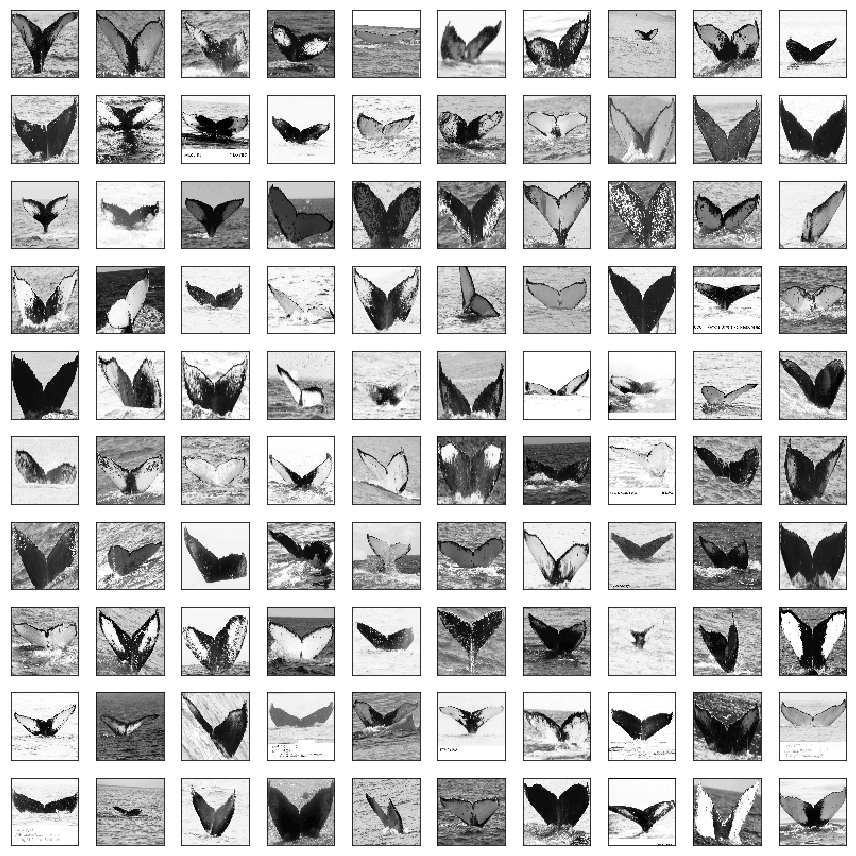

In [72]:
plotImages(x,10)

### Image augmentation with Keras prebuilt

In [73]:
x = x.reshape((-1,SIZE,SIZE,1))# shape of x
input_shape = x[0].shape# shape of input
x_train = x.astype("float32")
y_train = y_cat

In [74]:
image_gen = ImageDataGenerator(featurewise_center = True, 
                               samplewise_center = False, 
                               featurewise_std_normalization=True, 
                               samplewise_std_normalization=False, 
                               zca_whitening = True, 
                               zca_epsilon=1e-06, 
                               rotation_range = 10, 
                               width_shift_range=0.1, 
                               height_shift_range=0.1, 
                               shear_range=0.1, 
                               zoom_range=0.1, 
                               channel_shift_range=0.0, 
                               fill_mode='nearest', 
                               cval=0.0, 
                               horizontal_flip=False, 
                               vertical_flip=False, 
                               rescale=1./255, 
                               preprocessing_function=None, 
                               data_format = 'channels_last')
# fit parameters from data
image_gen.fit(x_train, augment=True)

### VGG16

In [94]:
from keras.layers import Input
from keras.utils.data_utils import get_file
from keras.layers import GlobalMaxPooling2D

WEIGHTS_PATH_NO_TOP = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'

batch_size = 128
num_classes = len(y_cat.toarray()[0])
epochs = 2

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')

img_input = Input(shape = input_shape)
print('input_shape:',img_input)

x_train shape: (9850, 64, 64, 1)
9850 train samples
input_shape: Tensor("input_6:0", shape=(?, 64, 64, 1), dtype=float32)


In [95]:
# 编写网络结构，prototxt
# Block 1
x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(img_input)
x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

# Block 2
x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

# Block 3
x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

# Block 4
x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)

# Block 5
x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1')(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2')(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)

# Classification block
x = Flatten(name='flatten')(x)
x = Dense(4096, activation='relu', name='fc1')(x)
x = Dense(4096, activation='relu', name='fc2')(x)
x = Dense(num_classes, activation='softmax', name='predictions')(x) #改变了输出数量

In [96]:
# Create model.
inputs = img_input
model = Model(inputs, x, name='vgg16')

In [97]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])
model.summary()
model.fit_generator(image_gen.flow(x_train, y_train.toarray(), batch_size=batch_size, shuffle=True, seed=123,),
                    steps_per_epoch = x_train.shape[0]//batch_size,
                    epochs = epochs,
                    class_weight = class_weight_dic)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 64, 64, 1)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        640       
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0         
__________

KeyboardInterrupt: 

### CNN

In [77]:
num_classes

4251

In [349]:
batch_size = 128
num_classes = len(y_cat.toarray()[0])
epochs = 9

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')

model = Sequential()
model.add(Conv2D(48, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(Conv2D(48, kernel_size=(3, 3), activation='sigmoid'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(48, kernel_size=(5, 5), activation='sigmoid'))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.33))
model.add(Flatten())
model.add(Dense(36, activation='sigmoid'))
model.add(Dropout(0.33))
model.add(Dense(36, activation='sigmoid'))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])
model.summary()
model.fit_generator(image_gen.flow(x_train, y_train.toarray(), batch_size=batch_size, shuffle=True, seed=123,),
                    steps_per_epoch = x_train.shape[0]//batch_size,
                    epochs = epochs,
                    class_weight = class_weight_dic)

#score = model.evaluate(x_train, y_train, verbose=0)
#print('Training loss: {0:.4f}\nTraining accuracy:  {1:.4f}'.format(*score))

x_train shape: (9850, 64, 64, 1)
9850 train samples
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 62, 62, 48)        480       
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 60, 60, 48)        20784     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 30, 30, 48)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 26, 26, 48)        57648     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 8, 8, 48)          0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 8, 8, 48)          0         
_________________________________________________________________
flatten_4 (Flatten)     

In [183]:
#K.clear_session()
#score = model.evaluate(x_train, y_train, verbose=0)
#print('Training loss: {0:.4f}\nTraining accuracy:  {1:.4f}'.format(*score))

In [272]:
with open("sample_submission.csv","w") as f:
    with warnings.catch_warnings():
        f.write("Image,Id\n")
        warnings.filterwarnings("ignore",category=DeprecationWarning)
        for image in test_images:
            img = ImportImage( image,SIZE)
            x = img.astype( "float32")
            #applying preprocessing to test images
            x = image_gen.standardize(x.reshape(1,SIZE,SIZE))

            #K.clear_session()
            y = model.predict_proba(x.reshape(1,SIZE,SIZE,1))
            predicted_args = np.argsort(y)[0][::-1][:5]
            predicted_tags = lohe.inverse_labels( predicted_args)
            image = split(image)[-1]
            predicted_tags = " ".join( predicted_tags)
            f.write("%s,%s\n" %(image, predicted_tags))

### Experiment Records

Epochs|Model|Augumentation|Loss on train|Accuracy on train|Loss on test|Accuracy on test|Score
-|-|-|-|-|-|-
9/9| CNN(Benchmark)| simple|4.1445|0.0811 |-|-|0.32660
9/9| CNN(Benchmark)| full  |4.1422|0.0814 |-|-|-
